In [1]:
'''

This code is part of the SIPN2 project focused on improving sub-seasonal to seasonal predictions of Arctic Sea Ice. 
If you use this code for a publication or presentation, please cite the reference in the README.md on the
main page (https://github.com/NicWayand/ESIO). 

Questions or comments should be addressed to nicway@uw.edu

Copyright (c) 2018 Nic Wayand

GNU General Public License v3.0


'''

'''
Plot forecast maps with all available models.
'''

%matplotlib inline
%load_ext autoreload
%autoreload
import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
from collections import OrderedDict
import itertools
import numpy as np
import numpy.ma as ma
import pandas as pd
import struct
import os
import xarray as xr
import glob
import datetime
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import seaborn as sns
np.seterr(divide='ignore', invalid='ignore')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import json
from esio import EsioData as ed
from esio import ice_plot
from esio import import_data
import subprocess
import dask
from dask.distributed import Client
import timeit

# General plotting settings
sns.set_style('whitegrid')
sns.set_context("talk", font_scale=.8, rc={"lines.linewidth": 2.5})

In [2]:
# # Set up local cluster for testing
# client = Client()
# client

In [3]:
E = ed.EsioData.load()

# add missing info for climatology
E.model_color['climatology'] = (0,0,0)
E.model_linestyle['climatology'] = '--'
E.model_marker['climatology'] = '*'
E.model['climatology'] = {'model_label':'Extrap.\n Clim. Trend'}
E.icePredicted['climatology'] = True

mod_dir = E.model_dir

# Define models to plot
models_2_plot = list(E.model.keys())
models_2_plot = [x for x in models_2_plot if x not in ['piomas','MME','MME_NEW','uclsipn']] # remove some models
models_2_plot = [x for x in models_2_plot if x not in ['modcansipns_3', 'modcansipns_4', 'szapirosipn', 'awispin', 'nicosipn']] # might return these in summer
models_2_plot = [x for x in models_2_plot if x not in ['noaasipn','noaasipn_ext']] # might return these in summer
models_2_plot = [x for x in models_2_plot if E.icePredicted[x]] # Only predictive models
models_2_plot = [x for x in models_2_plot if x not in ['usnavygofs']] # remove some models

print(models_2_plot)

models_2_plot = ['MME']+models_2_plot # Add models to always plot at top
models_2_plot.insert(1, models_2_plot.pop(-1)) # Move climatology from last to second

# arrange in order of models that have longest lead times
models_2_plot.insert(13, models_2_plot.pop(4)) # Move yopp
models_2_plot.insert(6, models_2_plot.pop(11)) # Move NESM-ext
models_2_plot.insert(7, models_2_plot.pop(10)) # Move KMA
models_2_plot.insert(7, models_2_plot.pop(15)) # Move fgoalssipn
#models_2_plot[1]='climo10yrs'
print(models_2_plot)

# add missing info for climo10yrs for future
E.model_color['climo10yrs'] = (0,0,0)
E.model_linestyle['climo10yrs'] = '--'
E.model_marker['climo10yrs'] = '*'
E.model['climo10yrs'] = {'model_label':'Climatology\nLast 10 Yrs'}
E.icePredicted['climo10yrs'] = True
#models_2_plot[1]='climo10yrs'


['dampedAnomalyTrend', 'gfdlsipn', 'yopp', 'ukmetofficesipn', 'ecmwfsipn', 'ecmwf', 'metreofr', 'ukmo', 'kma', 'ncep', 'usnavysipn', 'usnavyncep', 'rasmesrl', 'fgoalssipn', 'climatology']
['MME', 'climatology', 'dampedAnomalyTrend', 'gfdlsipn', 'ukmetofficesipn', 'ecmwfsipn', 'usnavysipn', 'fgoalssipn', 'kma', 'ecmwf', 'metreofr', 'ukmo', 'ncep', 'usnavyncep', 'yopp', 'rasmesrl']


In [4]:
print(models_2_plot)

models_2_plot_master ={0: models_2_plot,
                       1: models_2_plot,
                       2: models_2_plot,
                       3: models_2_plot[0:14],
                       4: models_2_plot[0:13],
                       5: models_2_plot[0:8],
                       6: models_2_plot[0:8],
                       7: models_2_plot[0:7],
                       8: models_2_plot[0:7],
                       9: models_2_plot[0:7]  }

for iweek in np.arange(0,10,1):
    print('for week  ',iweek,' models are:' ,models_2_plot_master[iweek])

['MME', 'climatology', 'dampedAnomalyTrend', 'gfdlsipn', 'ukmetofficesipn', 'ecmwfsipn', 'usnavysipn', 'fgoalssipn', 'kma', 'ecmwf', 'metreofr', 'ukmo', 'ncep', 'usnavyncep', 'yopp', 'rasmesrl']
for week   0  models are: ['MME', 'climatology', 'dampedAnomalyTrend', 'gfdlsipn', 'ukmetofficesipn', 'ecmwfsipn', 'usnavysipn', 'fgoalssipn', 'kma', 'ecmwf', 'metreofr', 'ukmo', 'ncep', 'usnavyncep', 'yopp', 'rasmesrl']
for week   1  models are: ['MME', 'climatology', 'dampedAnomalyTrend', 'gfdlsipn', 'ukmetofficesipn', 'ecmwfsipn', 'usnavysipn', 'fgoalssipn', 'kma', 'ecmwf', 'metreofr', 'ukmo', 'ncep', 'usnavyncep', 'yopp', 'rasmesrl']
for week   2  models are: ['MME', 'climatology', 'dampedAnomalyTrend', 'gfdlsipn', 'ukmetofficesipn', 'ecmwfsipn', 'usnavysipn', 'fgoalssipn', 'kma', 'ecmwf', 'metreofr', 'ukmo', 'ncep', 'usnavyncep', 'yopp', 'rasmesrl']
for week   3  models are: ['MME', 'climatology', 'dampedAnomalyTrend', 'gfdlsipn', 'ukmetofficesipn', 'ecmwfsipn', 'usnavysipn', 'fgoalssipn',

In [5]:
# Plotting Info
runType = 'forecast'
variables = ['sic']
metrics_all = {'sic':['anomaly','mean','SIP'], 'hi':['mean']}
updateAll = False

# Exclude some models
MME_NO = ['hcmr']

# Define Init Periods here, spaced by 7 days (aprox a week)
# Now
cd = datetime.datetime.now()
cd = datetime.datetime(cd.year, cd.month, cd.day) # Set hour min sec to 0. 
#cd = datetime.datetime(cd.year, 3, 4)  # force redo of period ending 2019-03-03
#cd = datetime.datetime(cd.year, 4, 20)  # force redo of 2019-04-14
#cd = datetime.datetime(cd.year, 4, 10)  # force redo of 2019-04-07

#cd = datetime.datetime(cd.year, 5, 8)  # force redo of 2019-04-07

# Hardcoded start date (makes incremental weeks always the same)
start_t = datetime.datetime(1950, 1, 1) # datetime.datetime(1950, 1, 1)
# Params for this plot
Ndays = 7 # time period to aggregate maps to (default is 7)
Npers =  7 # 5 number of periods to plot (from current date) (default is 14)
NweeksUpdate = 7 #3 # 3 Always update the most recent NweeksUpdate periods
init_slice = np.arange(start_t, cd, datetime.timedelta(days=Ndays)).astype('datetime64[ns]')
init_slice = init_slice[-Npers:] # Select only the last Npers of periods (weeks) since current date
print(init_slice)

# Forecast times to plot
weeks = pd.to_timedelta(np.arange(0,5,1), unit='W')
morewks = pd.to_timedelta([9,13,17,22,26], unit='W')
# months = pd.to_timedelta(np.arange(2,12,1), unit='M')
# years = pd.to_timedelta(np.arange(1,2), unit='Y') - np.timedelta64(1, 'D') # need 364 not 365
# slices = weeks.union(months).union(years).round('1d')
slices = weeks.union(morewks).round('1d')
da_slices = xr.DataArray(slices, dims=('fore_time'))
print('forecast time slices to plot in days:')
print(da_slices.fore_time.values.astype('timedelta64[D]'))

# Help conversion between "week/month" period used for figure naming and the actual forecast time delta value
int_2_days_dict = dict(zip(np.arange(0,da_slices.size), da_slices.values))
days_2_int_dict = {v: k for k, v in int_2_days_dict.items()}

['2019-05-26T00:00:00.000000000' '2019-06-02T00:00:00.000000000'
 '2019-06-09T00:00:00.000000000' '2019-06-16T00:00:00.000000000'
 '2019-06-23T00:00:00.000000000' '2019-06-30T00:00:00.000000000'
 '2019-07-07T00:00:00.000000000' '2019-07-14T00:00:00.000000000']
forecast time slices to plot in days:
[  0   7  14  21  28  63  91 119 154 182]


In [6]:
# Get median ice edge by DOY
median_ice_fill = xr.open_mfdataset(os.path.join(E.obs_dir, 'NSIDC_0051', 'agg_nc', 'ice_edge.nc')).sic
# Get mean sic by DOY
mean_1980_2010_sic = xr.open_dataset(os.path.join(E.obs_dir, 'NSIDC_0051', 'agg_nc', 'mean_1980_2010_sic.nc')).sic
# Get average sip by DOY
mean_1980_2010_SIP = xr.open_dataset(os.path.join(E.obs_dir, 'NSIDC_0051', 'agg_nc', 'hist_SIP_1980_2010.nc')).sip    


In [7]:
def get_figure_init_times(fig_dir):
    # Get list of all figures
    fig_files = glob.glob(os.path.join(fig_dir,'*.png'))
    init_times = list(reversed(sorted(list(set([os.path.basename(x).split('_')[3] for x in fig_files])))))
    return init_times

In [8]:
def update_status(ds_status=None, fig_dir=None, int_2_days_dict=None, NweeksUpdate=3):
    # Get list of all figures
    fig_files = glob.glob(os.path.join(fig_dir,'*.png'))
    # For each figure
    for fig_f in fig_files:
        # Get the init_time from file name
        cit = os.path.basename(fig_f).split('_')[3]
        # Get the forecast int from file name
        cft = int(os.path.basename(fig_f).split('_')[4].split('.')[0])
        # Check if current it and ft were requested, otherwise skip
        if (np.datetime64(cit) in ds_status.init_time.values) & (np.timedelta64(int_2_days_dict[cft]) in ds_status.fore_time.values):
            # Always update the last 3 weeks (some models have lagg before we get them)
            # Check if cit is one of the last NweeksUpdate init times in init_time
            if (np.datetime64(cit) not in ds_status.init_time.values[-NweeksUpdate:]):
                ds_status.status.loc[dict(init_time=cit, fore_time=int_2_days_dict[cft])] = 1
        
    return ds_status

In [9]:
ds_region = xr.open_dataset(os.path.join(E.grid_dir, 'sio_2016_mask_Update.nc'))
print(ds_region)
print(ds_region.region_names)

reg2plot = (2,3,4,6,7,8,9,10,11,12,13,15)
# Okhotsk, Bering, Hudson, Baffin+E. Grn., Barents+Kara, Laptev+E. Sib., Chuk+Beauf, Central
reg2plot = (2,3,4,(6,7),(8,9),(10,11),(12,13),15)

print(reg2plot)

<xarray.Dataset>
Dimensions:        (nregions: 21, ocean_regions: 14, x: 304, y: 448)
Coordinates:
    lat            (x, y) float64 ...
    lon            (x, y) float64 ...
    region_names   (nregions) object ...
  * x              (x) int64 0 1 2 3 4 5 6 7 ... 296 297 298 299 300 301 302 303
  * y              (y) int64 0 1 2 3 4 5 6 7 ... 440 441 442 443 444 445 446 447
    hole_mask      (y, x) int8 ...
    xm             (x) int64 ...
    ym             (y) int64 ...
  * nregions       (nregions) int64 1 2 3 4 5 6 7 8 ... 14 15 16 17 18 19 20 21
  * ocean_regions  (ocean_regions) int64 2 3 4 5 6 7 8 9 10 11 12 13 14 15
Data variables:
    mask           (x, y) int32 ...
    area           (x, y) float32 ...
<xarray.DataArray 'region_names' (nregions: 21)>
array(['Ice-free Oceans', 'Sea of Okhotsk', 'Bering', 'Hudson Bay', 'St John',
       'Baffin Bay', 'East Greenland Sea', 'Barents Sea', 'Kara Sea',
       'Laptev Sea', 'East Siberian Sea', 'Chukchi Sea', 'Beaufort Sea',
     

In [10]:
#plt.figure()
#tmp=ds_region.mask
#tmp=tmp.where(tmp<20,other=np.nan)
###ds_region.mask.plot()
#tmp.plot()

In [11]:
def Update_PanArctic_Maps():
    
    # Make requested dataArray as specified above
    ds_status = xr.DataArray(np.ones((init_slice.size, da_slices.size))*np.NaN, 
                             dims=('init_time','fore_time'), 
                             coords={'init_time':init_slice,'fore_time':da_slices}) 
    ds_status.name = 'status'
    ds_status = ds_status.to_dataset()


    # Check what plots we already have
    if not updateAll:
        print("Removing figures we have already made")
        ds_status = update_status(ds_status=ds_status, fig_dir=fig_dir, 
                                  int_2_days_dict=int_2_days_dict, 
                                  NweeksUpdate=NweeksUpdate)


    print(ds_status.status.values)
    # Drop IC/FT we have already plotted (orthoginal only)
    ds_status = ds_status.where(ds_status.status.sum(dim='fore_time')<ds_status.fore_time.size, drop=True)

    print("Starting plots...")
    # For each init_time we haven't plotted yet
        
    for it in ds_status.init_time.values: 
        start_time_cmod = timeit.default_timer()
        print(it)
        it_start = it-np.timedelta64(Ndays,'D') + np.timedelta64(1,'D') # Start period for init period (it is end of period). Add 1 day because when
        # we select using slice(start,stop) it is inclusive of end points. So here we are defining the start of the init AND the start of the valid time.
        # So we need to add one day, so we don't double count. 

        # For each forecast time we haven't plotted yet
        ft_to_plot = ds_status.sel(init_time=it)
        ft_to_plot = ft_to_plot.where(ft_to_plot.isnull(), drop=True).fore_time
        
        print('all forecast times to be plotted, ft_to_plot ',ft_to_plot.values)

        for ft in ft_to_plot.values: 

            print('Processing forecast time: ',ft.astype('timedelta64[D]'))

            ift = days_2_int_dict[ft] # index of ft
            cs_str = format(days_2_int_dict[ft], '02') # Get index of current forcast week
            week_str = format(iweek , '02') # Get string of current week
            cdoy_end = pd.to_datetime(it + ft).timetuple().tm_yday # Get current day of year end for valid time
            cdoy_start = pd.to_datetime(it_start + ft).timetuple().tm_yday  # Get current day of year end for valid time
            it_yr = str(pd.to_datetime(it).year) 
            it_m = str(pd.to_datetime(it).month)

            # Get datetime64 of valid time start and end
            valid_start = it_start + ft
            valid_end = it + ft
            
            print(ift)
            #if ift<=0:
            #    continue

            models_2_plot=models_2_plot_master[ift]
            print('models to plot ',models_2_plot)
            # Get # of models and setup subplot dims
            Nmod = len(models_2_plot) + 2  #(+3 for obs, MME, and clim)
            Nc = int(np.floor(np.sqrt(Nmod)))
            # Max number of columns == 5 (plots get too small otherwise)
            Nc = 5 #np.min([Nc,5])
            Nr = int(np.ceil((Nmod-1)/Nc))
            print(Nr, Nc, Nmod)
            assert Nc*Nr>=Nmod-1, 'Need more subplots'


            # Loop through variable of interest + any metrics (i.e. SIP) based on that
            for metric in metrics_all[cvar]:

                # Set up plotting info
                if cvar=='sic':
                    if metric=='mean':
                        cmap_c = matplotlib.colors.ListedColormap(sns.color_palette("Blues_r", 10))
                        cmap_c.set_bad(color = 'lightgrey')
                        c_label = 'Sea Ice Concentration (-)'
                        c_vmin = 0
                        c_vmax = 1
                    elif metric=='SIP':
                        cmap_c = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white","orange","red","#990000"])
                        cmap_c.set_bad(color = 'lightgrey')
                        c_label = 'Sea Ice Probability (-)'
                        c_vmin = 0
                        c_vmax = 1
                    elif metric=='anomaly':
#                         cmap_c = matplotlib.colors.ListedColormap(sns.color_palette("coolwarm", 9))
                        cmap_c = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","white","blue"])
                        cmap_c.set_bad(color = 'lightgrey')
                        c_label = 'SIC Anomaly to 1980-2010 Mean'
                        c_vmin = -1
                        c_vmax = 1

                elif cvar=='hi':
                    if metric=='mean':
                        cmap_c = matplotlib.colors.ListedColormap(sns.color_palette("Reds_r", 10))
                        cmap_c.set_bad(color = 'lightgrey')
                        c_label = 'Sea Ice Thickness (m)'
                        c_vmin = 0
                        c_vmax = None
                else:
                    raise ValueError("cvar not found.") 


                # New Plot
                (f, axes) = ice_plot.multi_polar_axis(ncols=Nc, nrows=Nr, 
                                              Nplots=Nmod)


                ############################################################################
                #                               OBSERVATIONS                               #
                ############################################################################

                # Plot Obs (if available)
                ax_num = 0
                axes[ax_num].set_title('Observed', fontsize=10)

                try:
                    da_obs_c = ds_ALL[metric].sel(model=b'Observed',init_end=it, fore_time=ft)
                    #print('da_obs_c',da_obs_c)
                    haveObs = True # we think there are obs...
                except KeyError:
                    haveObs = False

                rightnow = datetime.datetime.now()
                if valid_start > np.datetime64(rightnow):
                    haveObs = False  # but we know there are no obs in the future...

                # another brute force method
                nonnancount = np.count_nonzero(~np.isnan(da_obs_c.values))
                if nonnancount == 0:
                    haveObs = False  # no obs

                # If obs then plot
                if haveObs:
                    #da_obs_c = da_obs_c.where(ds_region.mask.isin(reg2plot[cR]))
                    da_obs_c.plot.pcolormesh(ax=axes[ax_num], x='lon', y='lat', 
                                          transform=ccrs.PlateCarree(),
                                          add_colorbar=False,
                                          cmap=cmap_c,
                                          vmin=c_vmin, vmax=c_vmax)
                    axes[ax_num].set_title('Observed', fontsize=10)     
                else: # When in the future (or obs are missing)
                    #print('no obs avail yet')
                    if metric=='SIP': # Plot this historical mean SIP 
                        print("plotting hist obs SIP")
                        da_obs_c = mean_1980_2010_SIP.isel(time=slice(cdoy_start,cdoy_end)).mean(dim='time')
                        da_obs_c.plot.pcolormesh(ax=axes[ax_num], x='lon', y='lat', 
                          transform=ccrs.PlateCarree(),
                          add_colorbar=False,
                          cmap=cmap_c,
                          vmin=c_vmin, vmax=c_vmax)
                        axes[ax_num].set_title('Hist. Obs.', fontsize=10)
                    else:
                        textstr = 'Not Available'
                        # these are matplotlib.patch.Patch properties
                        props = dict(boxstyle='round', facecolor='white', alpha=0.5)

                        # place a text box in upper left in axes coords
                        axes[ax_num].text(0.075, 0.55, textstr, transform=axes[ax_num].transAxes, fontsize=8,
                                verticalalignment='top', bbox=props)

                ############################################################################
                #                    Plot all models                                       #
                ############################################################################
                p = {}
                i=0
                for (i_nouse, cmod) in enumerate(models_2_plot):
                    #print(cmod)
                    i = i+1 # shift for obs
                    axes[i].set_title(E.model[cmod]['model_label'], fontsize=10)

                    # Select current model to plot
                    try:
                        ds_model = ds_ALL[metric].sel(model=cmod.encode('utf-8'),init_end=it, fore_time=ft)
                        haveMod = True
                    except:
                        haveMod = False

                    # another brute force method
                    nonnancount = np.count_nonzero(~np.isnan(ds_model.values))
                    if nonnancount == 0:
                        haveMod = False  # no output

                    # Plot
                    if haveMod:
                        # Select region
                        # Lat and Long feilds have round off differences, so set to same here
                        ds_model['lat'] = ds_region.lat
                        ds_model['lon'] = ds_region.lon
                        ds_model = ds_model.where(ds_region.mask<20, other = np.nan)

                        p[i] = ds_model.plot.pcolormesh(ax=axes[i], x='lon', y='lat', 
                                          transform=ccrs.PlateCarree(),
                                          add_colorbar=False,
                                          cmap=cmap_c,
                                          vmin=c_vmin, vmax=c_vmax)

                        axes[i].set_title(E.model[cmod]['model_label'], fontsize=10)

                        # Clean up for current model
                        ds_model = None

                    else:
                        textstr = 'Not Available'
                        # these are matplotlib.patch.Patch properties
                        props = dict(boxstyle='round', facecolor='white', alpha=0.5)

                        # place a text box in upper left in axes coords
                        axes[i].text(0.075, 0.55, textstr, transform=axes[i].transAxes, fontsize=8,
                                verticalalignment='top', bbox=props)


                # Make pretty
                f.subplots_adjust(right=0.8)
                cbar_ax = f.add_axes([0.85, 0.15, 0.05, 0.7])
                if p: # if its not empty
                    cbar = f.colorbar(next(iter(p.values())), cax=cbar_ax, label=c_label) # use first plot to gen colorbar
                    if metric=='anomaly':
                        cbar.set_ticks(np.arange(-1,1.1,0.2))
                    else:
                        cbar.set_ticks(np.arange(0,1.1,0.1))

                # Set title of all plots
                init_time_2 =  pd.to_datetime(it).strftime('%Y-%m-%d')
                init_time_1 =  pd.to_datetime(it_start).strftime('%Y-%m-%d')
                valid_time_2 = pd.to_datetime(it+ft).strftime('%Y-%m-%d')
                valid_time_1 = pd.to_datetime(it_start+ft).strftime('%Y-%m-%d')
                if ift<3: 
                    titlesize=15
                elif ift<5:
                    titlesize=13
                else:
                    titlesize=11
                plt.suptitle('Initialization Time: '+init_time_1+' to '+init_time_2+'\n Valid Time: '+valid_time_1+' to '+valid_time_2,
                             fontsize=titlesize) # +'\n Week '+week_str

                if (ift>4):
                    plt.subplots_adjust(top=0.75)
                else:
                    plt.subplots_adjust(top=0.85)

                # Save to file
                f_out = os.path.join(fig_dir,'panArctic_'+metric+'_'+runType+'_'+init_time_2+'_'+cs_str+'.png')
                f.savefig(f_out,bbox_inches='tight', dpi=200)
                print("saved ", f_out)
                #print("Figure took  ", (timeit.default_timer() - start_time_plot)/60, " minutes.")

                # Mem clean up
                p = None
                plt.close(f)
                da_obs_c = None

                #diehere

        # end of plot

        # Done with current it
        print("Took ", (timeit.default_timer() - start_time_cmod)/60, " minutes.")


    # Update json file
    json_format = get_figure_init_times(fig_dir)
    json_dict = [{"date":cd,"label":cd} for cd in json_format]

    json_f = os.path.join(fig_dir, 'plotdates_current.json')
    with open(json_f, 'w') as outfile:
        json.dump(json_dict, outfile)

    # Make into Gifs
    # TODO: make parallel, add &
#    for cit in json_format:
#        subprocess.call(str("/home/disk/sipn/nicway/python/ESIO/scripts/makeGif.sh " + fig_dir + " " + cit), shell=True)

    print("Finished plotting panArctic Maps.")

Removing figures we have already made
[[nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]]
Starting plots...
2019-05-26T00:00:00.000000000
all forecast times to be plotted, ft_to_plot  [                0   604800000000000  1209600000000000  1814400000000000
  2419200000000000  5443200000000000  7862400000000000 10281600000000000
 13305600000000000 15724800000000000]
Processing forecast time:  0 days
0
models to plot  ['MME', 'climatology', 'dampedAnomalyTrend', 'gfdlsipn', 'ukmetofficesipn', 'ecmwfsipn', 'usnavysipn', 'fgoalssipn', 'kma', 'ecmwf', 'metreofr', 'ukmo', 'ncep', 'usnavyncep', 'yopp', 'rasmesrl']
4 5 18
saved  /home/disk/sipn/nicway/public_html/sipn/figures/model/all_model/sic/maps_weekl

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


saved  /home/disk/sipn/nicway/public_html/sipn/figures/model/all_model/sic/maps_weekly_NEW/panArctic_SIP_forecast_2019-05-26_05.png
Processing forecast time:  91 days
6
models to plot  ['MME', 'climatology', 'dampedAnomalyTrend', 'gfdlsipn', 'ukmetofficesipn', 'ecmwfsipn', 'usnavysipn', 'fgoalssipn']
2 5 10
saved  /home/disk/sipn/nicway/public_html/sipn/figures/model/all_model/sic/maps_weekly_NEW/panArctic_anomaly_forecast_2019-05-26_06.png
saved  /home/disk/sipn/nicway/public_html/sipn/figures/model/all_model/sic/maps_weekly_NEW/panArctic_mean_forecast_2019-05-26_06.png
plotting hist obs SIP


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


saved  /home/disk/sipn/nicway/public_html/sipn/figures/model/all_model/sic/maps_weekly_NEW/panArctic_SIP_forecast_2019-05-26_06.png
Processing forecast time:  119 days
7
models to plot  ['MME', 'climatology', 'dampedAnomalyTrend', 'gfdlsipn', 'ukmetofficesipn', 'ecmwfsipn', 'usnavysipn']
2 5 9
saved  /home/disk/sipn/nicway/public_html/sipn/figures/model/all_model/sic/maps_weekly_NEW/panArctic_anomaly_forecast_2019-05-26_07.png
saved  /home/disk/sipn/nicway/public_html/sipn/figures/model/all_model/sic/maps_weekly_NEW/panArctic_mean_forecast_2019-05-26_07.png
plotting hist obs SIP


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


saved  /home/disk/sipn/nicway/public_html/sipn/figures/model/all_model/sic/maps_weekly_NEW/panArctic_SIP_forecast_2019-05-26_07.png
Processing forecast time:  154 days
8
models to plot  ['MME', 'climatology', 'dampedAnomalyTrend', 'gfdlsipn', 'ukmetofficesipn', 'ecmwfsipn', 'usnavysipn']
2 5 9
saved  /home/disk/sipn/nicway/public_html/sipn/figures/model/all_model/sic/maps_weekly_NEW/panArctic_anomaly_forecast_2019-05-26_08.png
saved  /home/disk/sipn/nicway/public_html/sipn/figures/model/all_model/sic/maps_weekly_NEW/panArctic_mean_forecast_2019-05-26_08.png
plotting hist obs SIP


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


saved  /home/disk/sipn/nicway/public_html/sipn/figures/model/all_model/sic/maps_weekly_NEW/panArctic_SIP_forecast_2019-05-26_08.png
Processing forecast time:  182 days
9
models to plot  ['MME', 'climatology', 'dampedAnomalyTrend', 'gfdlsipn', 'ukmetofficesipn', 'ecmwfsipn', 'usnavysipn']
2 5 9
saved  /home/disk/sipn/nicway/public_html/sipn/figures/model/all_model/sic/maps_weekly_NEW/panArctic_anomaly_forecast_2019-05-26_09.png
saved  /home/disk/sipn/nicway/public_html/sipn/figures/model/all_model/sic/maps_weekly_NEW/panArctic_mean_forecast_2019-05-26_09.png
plotting hist obs SIP


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


saved  /home/disk/sipn/nicway/public_html/sipn/figures/model/all_model/sic/maps_weekly_NEW/panArctic_SIP_forecast_2019-05-26_09.png
Took  4.77380952766689  minutes.
2019-06-02T00:00:00.000000000
all forecast times to be plotted, ft_to_plot  [                0   604800000000000  1209600000000000  1814400000000000
  2419200000000000  5443200000000000  7862400000000000 10281600000000000
 13305600000000000 15724800000000000]
Processing forecast time:  0 days
0
models to plot  ['MME', 'climatology', 'dampedAnomalyTrend', 'gfdlsipn', 'ukmetofficesipn', 'ecmwfsipn', 'usnavysipn', 'fgoalssipn', 'kma', 'ecmwf', 'metreofr', 'ukmo', 'ncep', 'usnavyncep', 'yopp', 'rasmesrl']
4 5 18
saved  /home/disk/sipn/nicway/public_html/sipn/figures/model/all_model/sic/maps_weekly_NEW/panArctic_anomaly_forecast_2019-06-02_00.png
saved  /home/disk/sipn/nicway/public_html/sipn/figures/model/all_model/sic/maps_weekly_NEW/panArctic_mean_forecast_2019-06-02_00.png
saved  /home/disk/sipn/nicway/public_html/sipn/figur

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


KeyboardInterrupt: 

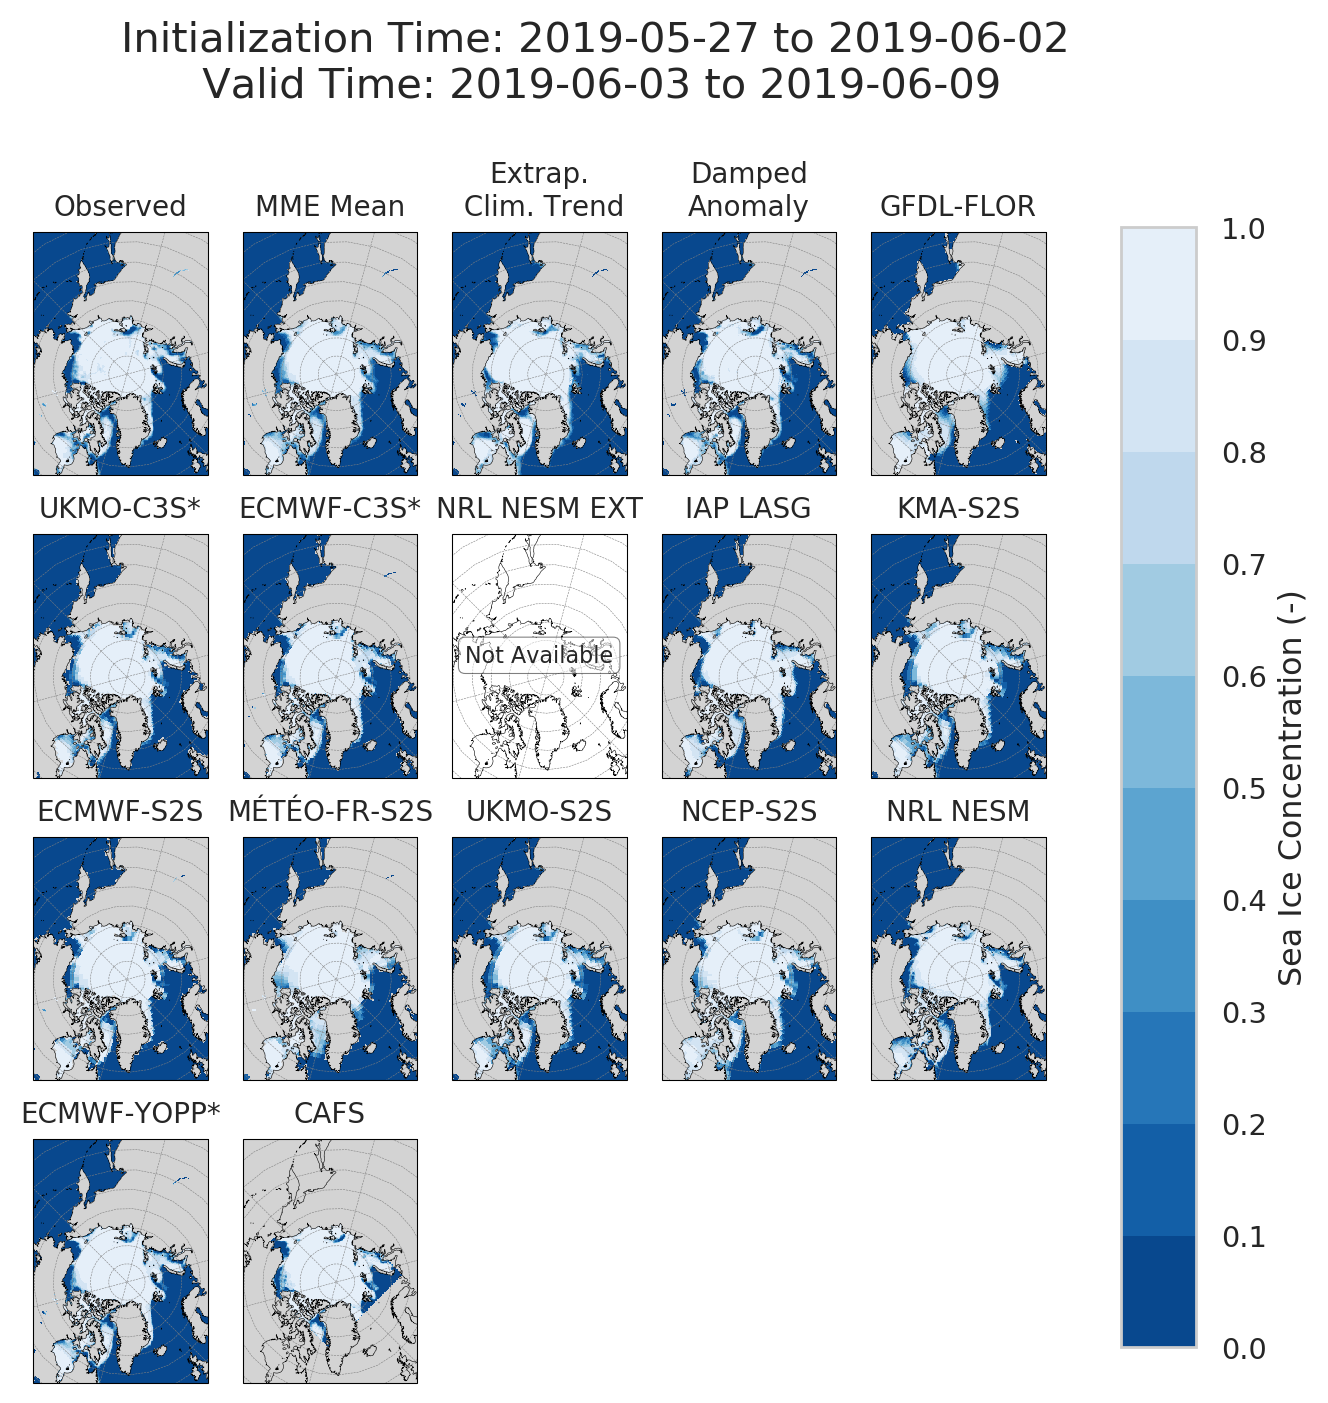

In [12]:
if __name__ == '__main__':
    # Start up Client
    client = Client(n_workers=8)
    # dask.config.set(scheduler='threads')  # overwrite default with threaded scheduler
    
    #############################################################
    # Load in Data
    #############################################################

    for cvar in variables:

        # Load in dask data from Zarr
        ds_ALL = xr.open_zarr(os.path.join(E.data_dir,'model/zarr',cvar+'.zarr'))

        # Define fig dir and make if doesn't exist
        fig_dir = os.path.join(E.fig_dir, 'model', 'all_model', cvar, "maps_weekly_NEW")
        if not os.path.exists(fig_dir):
            os.makedirs(fig_dir)

        # Call function
        Update_PanArctic_Maps()


In [ ]:
#client.close()